<a href="https://colab.research.google.com/github/samersonal/Toxic-Comments-Classification/blob/main/Toxic_Comments_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Installing dependencies

In [9]:
import os
import tensorflow as tf # Deep learning framework to use Keras
import pandas as pd
import numpy as np

## 1. Preprocessing the data

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Practice Projects/Toxic Comments Classification/train.csv')
#os.path.join('') #Give the path of the folder


In [11]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [12]:
df.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [13]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [15]:
df.iloc[6]['comment_text'] # Toxic comment example

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [16]:
#df = df.head(10000) To the number of samples

## 2. Preprocessing the comments

In [17]:
from tensorflow.keras.layers import TextVectorization #This layer will tokenize the words in the comments column.
##TextVectorization??

In [18]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [19]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [20]:
MAX_FEATURES = 200000 # give us how many words we want in the vector vocab

vectorizer = TextVectorization(max_tokens = MAX_FEATURES, output_sequence_length = 1800, output_mode = 'int') #output_sequqnce_length is max sentence length in tokens


In [21]:
vectorizer.adapt(X.values) #X.values is a numpy array of the comments; adapt will learn the volabulary in the X.values

In [60]:
vectorizer.get_vocabulary()[:10] # gives the words and position in the array.

['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'you', 'i', 'is']

In [23]:
test = "Hello! She is beautiful!"
vectorizer(test)[:4] #Strips out punctuations

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 288,  220,    9, 2977])>

In [24]:
vectorize_text = vectorizer(X.values)

In [25]:
#tensorflow Data pipeline MCSHBAP = #map, cache, shuffe, batch, prefetch from from tensor_slices, list_files # useful when data is large and can't into memory.
dataset = tf.data.Dataset.from_tensor_slices((vectorize_text, y)) #each element of the dataset is a comment and target label
dataset = dataset.cache()
dataset = dataset.shuffle(1600000) # 1600000 samples of comments
dataset = dataset.batch(1024) #Each batch
dataset = dataset.prefetch(8) #Helps prevents bottlenecks


In [26]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [27]:
batch_X.shape


(1024, 1800)

In [28]:
batch_y.shape

(1024, 6)

In [29]:
#Splitting the data into training , validation and testing set
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [30]:
train_generator = train.as_numpy_iterator()

In [31]:
train_generator.next() # Deep learning model in each epoch will take batch do a forward pass, backward pass update the gradient.

(array([[ 972,    1,  288, ...,    0,    0,    0],
        [ 484,   77,   16, ...,    0,    0,    0],
        [   7,   19,  137, ...,    0,    0,    0],
        ...,
        [ 339,    7,   19, ...,    0,    0,    0],
        [   8,  243,  120, ...,    0,    0,    0],
        [  76,   33, 2574, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

## 3. Create a sequential model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dropout, Bidirectional, Dense, Embedding

In [33]:
model = Sequential()
#Create the embedding layer
model.add(Embedding(MAX_FEATURES+1,32)) # Each word will have 32 value embeddings , need to add 1 for unknown words
#LSTM layer will have 32 units ,
model.add(Bidirectional(LSTM(32, activation='tanh'))) #Used particularly on sentences ex I don't hate you LSTM may find hate and score it negative but biLSTM will take in don't as well.

#Feature extractor of fully connected layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(258, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

#Final Layer - Maps to the output of 6 labels
model.add(Dense(6, activation = 'sigmoid')) #outputs will be in between 0 and 1

In [34]:
model.compile(loss = 'BinaryCrossentropy' , optimizer = 'Adam')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 258)               33282     
                                                                 
 dense_2 (Dense)             (None, 128)               33152     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [36]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
history = model.fit(train, validation_data = val, epochs =10) #This dataset will need 3-4 epochs but limiting to only 1 due to time contraints

Epoch 1/10
109/109 [==============================] - 53s 408ms/step - loss: 0.1854 - val_loss: 0.0703
Epoch 2/10
109/109 [==============================] - 42s 380ms/step - loss: 0.0581 - val_loss: 0.0490
Epoch 3/10
109/109 [==============================] - 41s 373ms/step - loss: 0.0472 - val_loss: 0.0421
Epoch 4/10
109/109 [==============================] - 40s 363ms/step - loss: 0.0421 - val_loss: 0.0389
Epoch 5/10
109/109 [==============================] - 40s 365ms/step - loss: 0.0383 - val_loss: 0.0361
Epoch 6/10
109/109 [==============================] - 38s 345ms/step - loss: 0.0367 - val_loss: 0.0344
Epoch 7/10
109/109 [==============================] - 38s 346ms/step - loss: 0.0343 - val_loss: 0.0320
Epoch 8/10
109/109 [==============================] - 37s 338ms/step - loss: 0.0336 - val_loss: 0.0307
Epoch 9/10
109/109 [==============================] - 35s 323ms/step - loss: 0.0321 - val_loss: 0.0289
Epoch 10/10
109/109 [==============================] - 36s 330ms/step - l

In [38]:
history.history

{'loss': [0.18537360429763794,
  0.0581025555729866,
  0.047192372381687164,
  0.042108550667762756,
  0.038268741220235825,
  0.03667080029845238,
  0.03434775769710541,
  0.03363635763525963,
  0.03209422156214714,
  0.030562199652194977],
 'val_loss': [0.07030265033245087,
  0.04901982098817825,
  0.04207206144928932,
  0.038939718157052994,
  0.03605014830827713,
  0.0344330295920372,
  0.03201746195554733,
  0.030688202008605003,
  0.028871797025203705,
  0.028126295655965805]}

<Figure size 400x400 with 0 Axes>

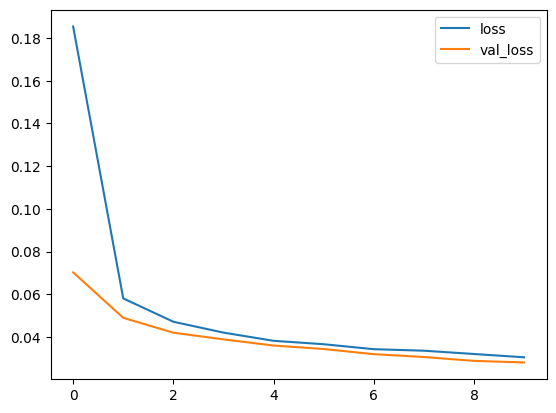

In [61]:

from matplotlib import pyplot as plt

plt.figure(figsize = (4,4))
pd.DataFrame(history.history).plot()
plt.show()

## Make predictions

In [40]:
text = vectorizer('You suck!, please die, you cocksucker dimwight, nigga!')

In [41]:
text #Tokenize values

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  7, 397,  46, ...,   0,   0,   0])>

In [42]:
model.predict(np.expand_dims(text,0)) #increase the dimension the input

1/1 [==============================] - 1s 779ms/step


array([[0.9995882 , 0.6462597 , 0.9940718 , 0.02493741, 0.9337647 ,
        0.13607043]], dtype=float32)

In [43]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [44]:
batch_x , batch_y = test.as_numpy_iterator().next()

In [45]:
(model.predict(batch_x)>0.5).astype(int)

32/32 [==============================] - 2s 58ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [46]:
model.save('/content/drive/MyDrive/Practice Projects/Toxic Comments Classification/ToxicModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [48]:
model1 = load_model('/content/drive/MyDrive/Practice Projects/Toxic Comments Classification/ToxicModel.h5')

## Evaluate the model

In [50]:
#Know if model is performing well.
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [51]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [57]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch #unpacking the values
  yhat = (model.predict(X_true) >0.5).astype(int)
  y_true = y_true.flatten()
  yhat = yhat.flatten()


  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)



32/32 [==============================] - 1s 38ms/step


In [59]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8666986227035522, Recall: 0.8095735311508179, Accuracy: 0.46666666865348816
